In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# 2D convolutions


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy import signal
from scipy import linalg
import time

Consider a 2D signal $\mathbf{v}$ representing a picture


(np.float64(-0.5), np.float64(496.5), np.float64(371.5), np.float64(-0.5))

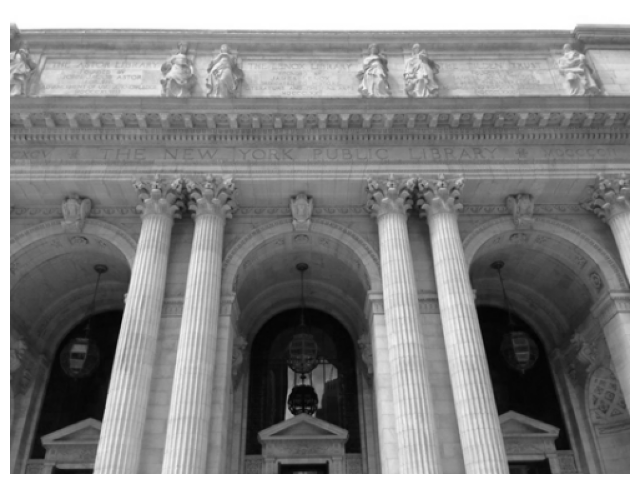

In [3]:
# write here the import path of the image
image_path = "data_labs/NYlibrary.png"

v = np.mean(imread(image_path), axis=2)

plt.rcParams["figure.figsize"] = [8, 8]

vmin = v.min()
vmax = v.max()
img = plt.imshow(v, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

Consider the following kernels


In [4]:
kernel_blur1 = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
kernel_blur1 = kernel_blur1 / np.sum(kernel_blur1)

kernel_blur2 = np.ones((10, 10)) / 100

kernel_edge1 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel_edge2 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
kernel_edge3 = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])

kernel_sobel_horizontal = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
kernel_sobel_vertical = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

kernel_drunk = np.random.randn(50, 50)

Choose here the desired filter $\mathbf{k}$


In [5]:
k = kernel_blur1

In what follows, we will compute the convolution between $\mathbf{v}$ and $\mathbf{k}$ in 4 different manners. At the end of each point, plot the obtained filtered (i.e. convolved) signal.


## 1. Direct definition (sums of products)

Convolution without "boundary layers"


Execution time: 1.82e+00 s


(np.float64(-0.5), np.float64(494.5), np.float64(369.5), np.float64(-0.5))

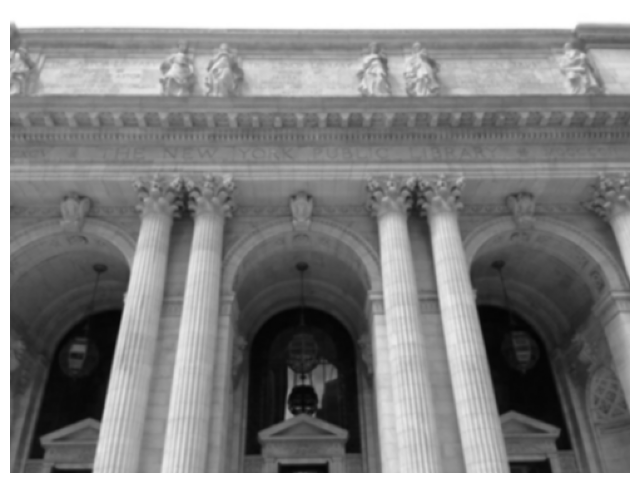

In [6]:
t0 = time.time()

s1 = np.array(v.shape)
s2 = np.array(k.shape)
s_out = s1 - s2 + 1
v_conv1 = np.empty(s_out)
for i in range(s_out[0]):
    for j in range(s_out[1]):
        v_conv1[i, j] = np.sum(np.flip(k) * v[i : i + s2[0], j : j + s2[1]])

print("Execution time: %1.2e s" % (time.time() - t0))

img = plt.imshow(v_conv1, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

Execution time: 1.70e+00 s


(np.float64(-0.5), np.float64(494.5), np.float64(369.5), np.float64(-0.5))

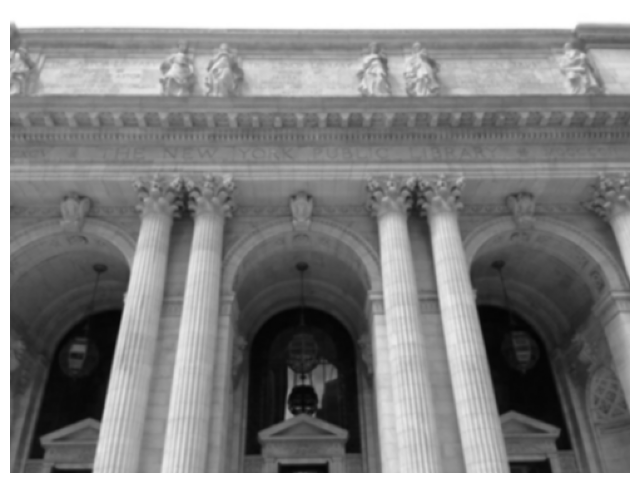

In [7]:
t0 = time.time()

s1 = np.array(v.shape)
s2 = np.array(k.shape)
s_out = s1 - s2 + 1
v_conv1 = np.array(
    [
        [np.sum(np.flip(k) * v[i : i + s2[0], j : j + s2[1]]) for j in range(s_out[1])]
        for i in range(s_out[0])
    ]
)

print("Execution time: %1.2e s" % (time.time() - t0))

img = plt.imshow(v_conv1, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

## 2. Convolution through DFT

Besides the filtered image, plot the DFT of the original image, of the kernel and of the filtered image.


Execution time: 6.36e-02 s


C:\Users\manse\AppData\Local\Temp\ipykernel_17696\2316306307.py:19: RuntimeWarning: divide by zero encountered in log10
  img = axs[1, 0].imshow(fftshift(np.log10(np.absolute(vk_fft))))


(np.float64(-0.5), np.float64(496.5), np.float64(371.5), np.float64(-0.5))

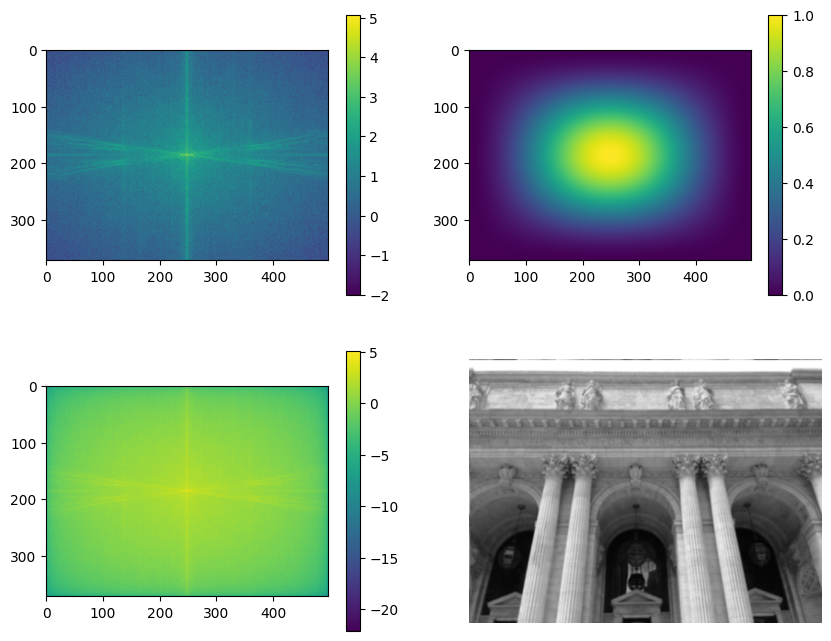

In [8]:
from numpy.fft import ifft2, fft2, fftshift, fftfreq

t0 = time.time()

v_fft = fft2(v)
k_fft = fft2(k, v.shape)

vk_fft = v_fft * k_fft

v_conv2 = np.real(ifft2(vk_fft))

print("Execution time: %1.2e s" % (time.time() - t0))

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
img = axs[0, 0].imshow(fftshift(np.log10(np.absolute(v_fft))))
fig.colorbar(img, ax=axs[0, 0])
img = axs[0, 1].imshow(fftshift((np.absolute(k_fft))))
fig.colorbar(img, ax=axs[0, 1])
img = axs[1, 0].imshow(fftshift(np.log10(np.absolute(vk_fft))))
fig.colorbar(img, ax=axs[1, 0])
axs[1, 1].imshow(v_conv2, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

## 3. Using the command `scipy.signal.convolve`

Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).


Execution time: 3.61e-02 s


(np.float64(-0.5), np.float64(496.5), np.float64(371.5), np.float64(-0.5))

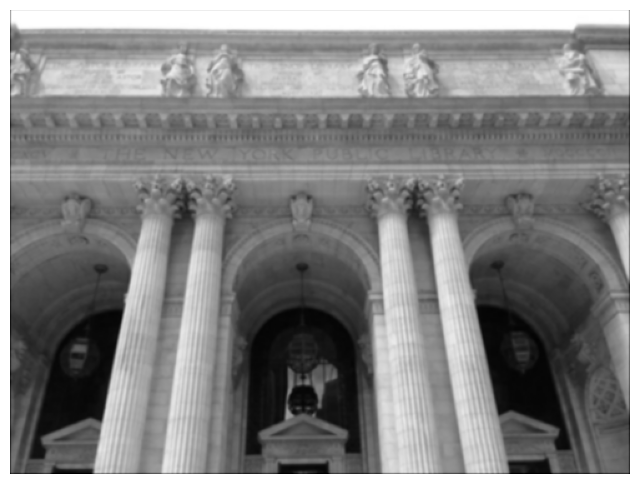

In [9]:
t0 = time.time()

v_conv3 = signal.convolve(v, k, mode="same")

print("Execution time: %1.2e s" % (time.time() - t0))

img = plt.imshow(v_conv3, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

In [10]:
import jax


def convolve_same_xla_2d(v, k):
    # Reshape kernel for 2D convolution: [filter_height, filter_width, in_channels, out_channels]
    kernel = k[:, :, None, None]  # Add input and output channel dimensions
    # Reshape input for 2D convolution: [batch_size, height, width, in_channels]
    input_array = v[None, :, :, None]  # Add batch and channel dimensions

    # Calculate padding for "same" mode
    pad_height = (k.shape[0] - 1) // 2
    pad_width = (k.shape[1] - 1) // 2
    padding = [(pad_height, pad_height), (pad_width, pad_width)]  # symmetric padding

    # Perform 2D convolution with XLA
    result = jax.lax.conv_general_dilated(
        input_array,  # Input array
        kernel,  # Kernel
        window_strides=(1, 1),  # Stride of 1 for both dimensions
        padding=padding,  # "Same"-like padding
        dimension_numbers=("NHWC", "HWIO", "NHWC"),  # Data and kernel format
    )

    # Reshape the result to a 2D array
    return result[0, :, :, 0]  # Remove batch and channel dimensions


vj = jax.numpy.array(v, dtype=jax.numpy.float32)
kj = jax.numpy.array(k, dtype=jax.numpy.float32)


t0 = time.time()
v_conv4 = convolve_same_xla_2d(vj, kj)
print("Execution time: %1.2e s" % (time.time() - t0))

np.abs(v_conv4 - v_conv3).max()

Execution time: 1.30e-01 s


np.float32(2.3841858e-07)